<a href="https://colab.research.google.com/github/yianan261/CS6220/blob/main/DataMiningProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, classification_report

# Dataset
Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, “Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records,” BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014.

In [ ]:
# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

# data (as pandas dataframes)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

# metadata
print(diabetes_130_us_hospitals_for_years_1999_2008.metadata)

# variable information
print("variable",diabetes_130_us_hospitals_for_years_1999_2008.variables)

{'uci_id': 296, 'name': 'Diabetes 130-US hospitals for years 1999-2008', 'repository_url': 'https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008', 'data_url': 'https://archive.ics.uci.edu/static/public/296/data.csv', 'abstract': 'The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the early readmission of the patient within 30 days of discharge.\nThe problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide pro

/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


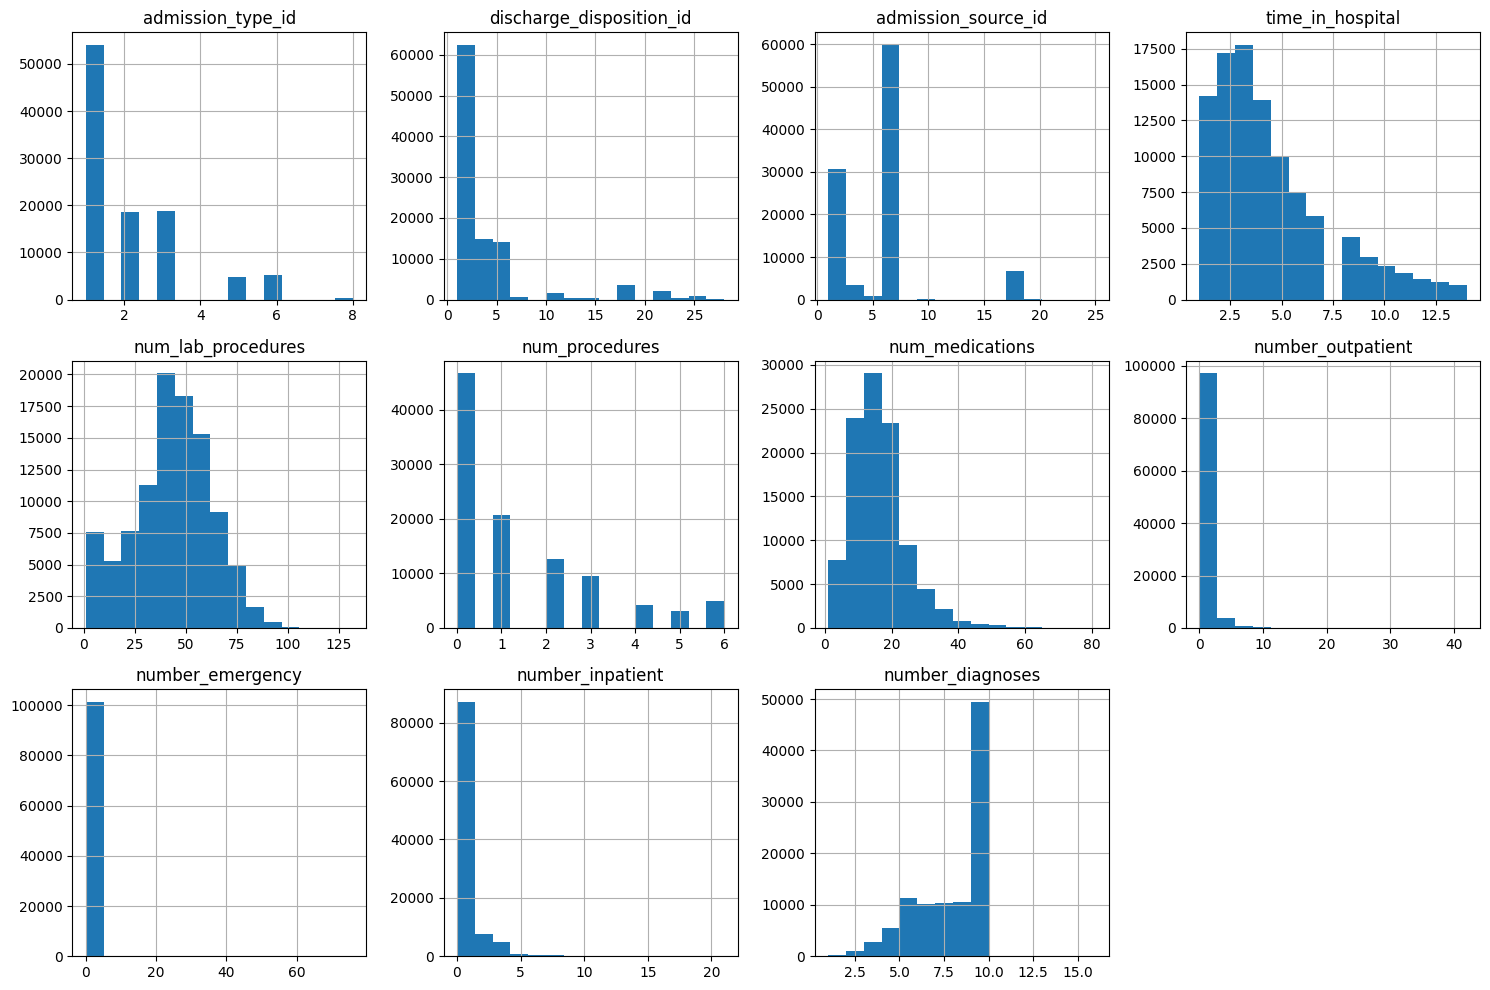

In [ ]:
#@title Data visualization

X.hist(bins=15, figsize=(15, 10), layout=(-1, 4)) # layout=(-1, 4) means 4 columns per row and as many rows as needed
plt.tight_layout()
plt.show()

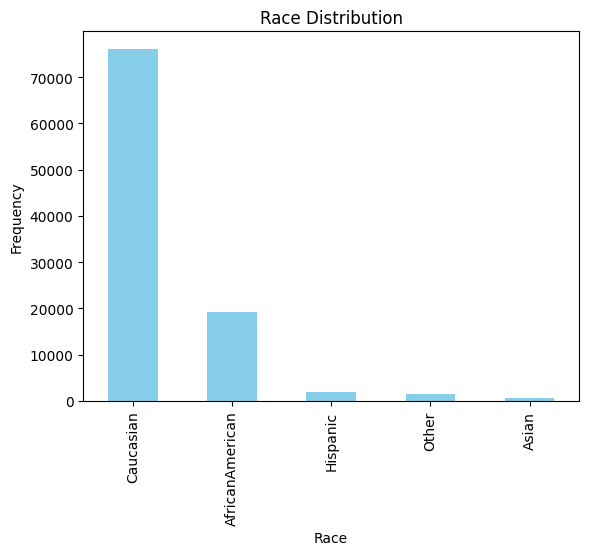

In [ ]:
race_counts = X['race'].value_counts()

# Plot a bar chart
race_counts.plot(kind='bar', color='skyblue')

# Set the title and labels
plt.title('Race Distribution')
plt.xlabel('Race')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [ ]:
y['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

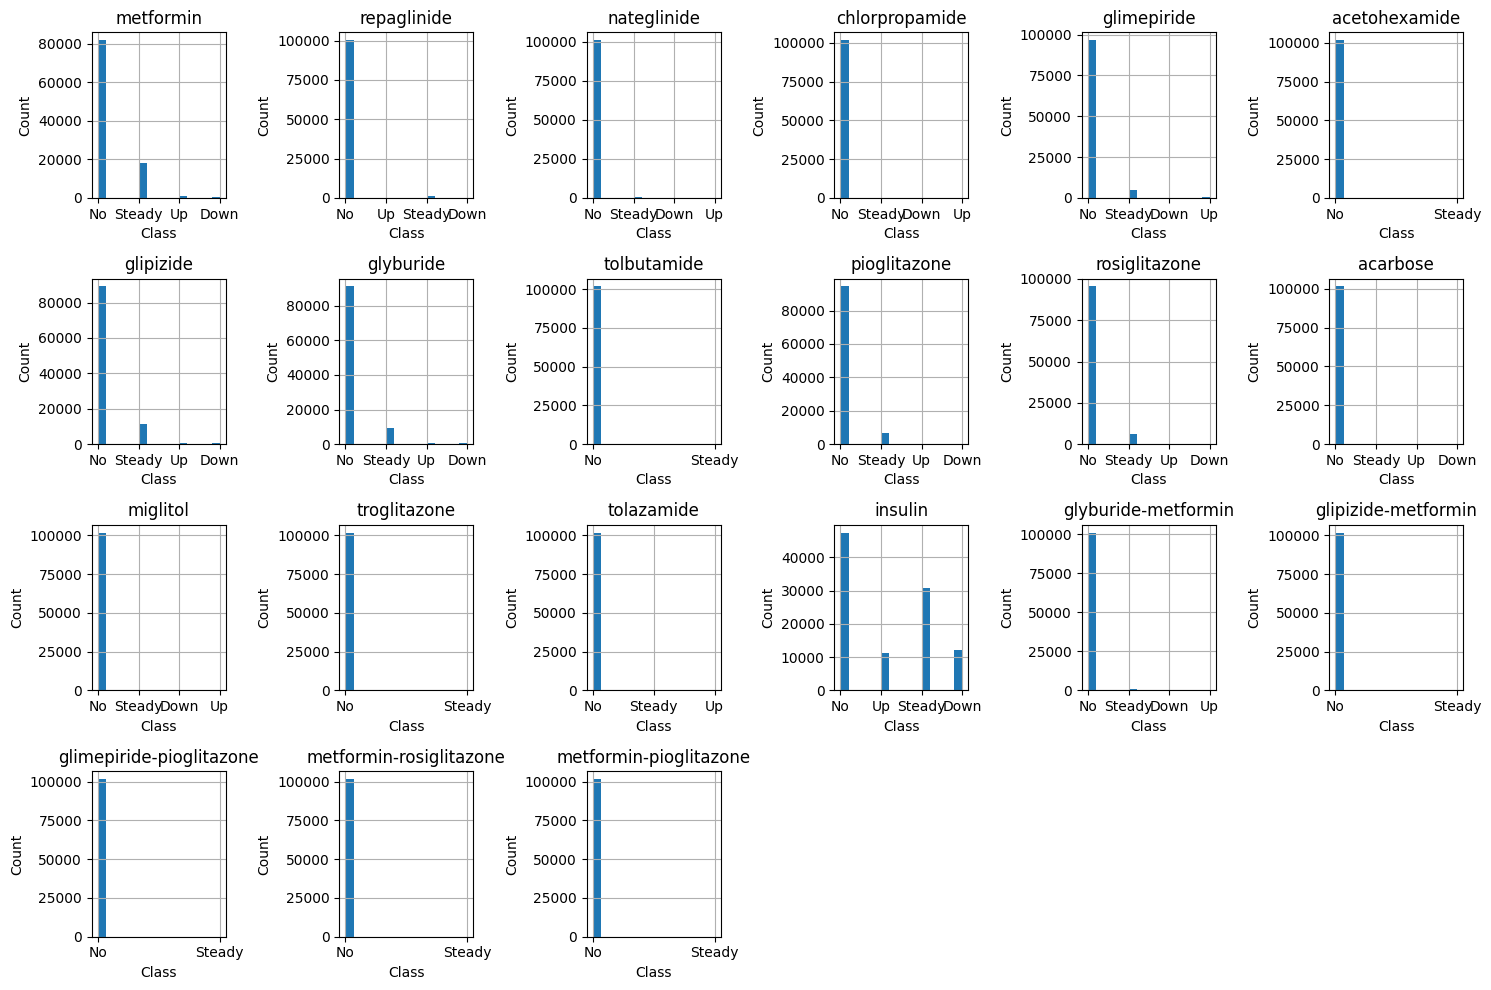

In [ ]:
#@title Data visualization
# List of columns to plot
columns_to_plot = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
                   'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
                   'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin',
                   'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
                   'metformin-rosiglitazone', 'metformin-pioglitazone']

# Set up the figure and axes
plt.figure(figsize=(15, 10))

# Iterate through columns and plot histograms
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(4, 6, i)  # Adjust the layout based on the number of columns
    X[column].hist(bins=15)
    plt.title(column)
    plt.xlabel("Class")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:
#@title Data Preprocess: Consider medication column to drop

# List of columns corresponding to medications
med_drop = []
medication_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
                      'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
                      'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin',
                      'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
                      'metformin-rosiglitazone', 'metformin-pioglitazone']
total = 0
for medication_column in medication_columns:
    value_counts = X[medication_column].value_counts()
    count = 0
    for value in [1, 2, 3]:
      count += value_counts.get(value, 0)
    if count < 100:
      print(value_counts)
      print(f"Consider to drop '{medication_column}: {count}")
      med_drop.append(medication_column)
      total += 1
    print()
print(len(med_drop))
print([med for med in med_drop])




No        101680
Steady        79
Up             6
Down           1
Name: chlorpropamide, dtype: int64
Consider to drop 'chlorpropamide: 86


No        101765
Steady         1
Name: acetohexamide, dtype: int64
Consider to drop 'acetohexamide: 1



No        101743
Steady        23
Name: tolbutamide, dtype: int64
Consider to drop 'tolbutamide: 23




No        101728
Steady        31
Down           5
Up             2
Name: miglitol, dtype: int64
Consider to drop 'miglitol: 38

No        101763
Steady         3
Name: troglitazone, dtype: int64
Consider to drop 'troglitazone: 3

No        101727
Steady        38
Up             1
Name: tolazamide, dtype: int64
Consider to drop 'tolazamide: 39



No        101753
Steady        13
Name: glipizide-metformin, dtype: int64
Consider to drop 'glipizide-metformin: 13

No        101765
Steady         1
Name: glimepiride-pioglitazone, dtype: int64
Consider to drop 'glimepiride-pioglitazone: 1

No        101764
Steady         2
Name: metformin-ros

In [ ]:
#@title Data Preprocessing: Dropping columns with high proportion of missing values

non_missing_counts = X.apply(lambda col: col[col != '?'].count())

proportion_non_missing = non_missing_counts / len(X)

proportion_nan = X.isna().mean()
threshold = 0.20

columns_to_drop = proportion_non_missing[proportion_nan > threshold].index.tolist()
drop = ['examide', 'citoglipton', 'number_emergency', 'diag_2', 'diag_3', 'number_inpatient', 'number_outpatient','chlorpropamide', 'acetohexamide', 'tolbutamide', 'miglitol', 'troglitazone', 'tolazamide', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone','glipizide','nateglinide',]
columns_to_drop.extend(drop)
print("columns to drop", columns_to_drop)
X_data = X.drop(columns=columns_to_drop)

unique_values = {col: X_data[col].unique() for col in X_data.columns}

for col, values in unique_values.items():
    print(f"{col}: {values}")

columns to drop ['weight', 'payer_code', 'medical_specialty', 'examide', 'citoglipton', 'number_emergency', 'diag_2', 'diag_3', 'number_inpatient', 'number_outpatient', 'chlorpropamide', 'acetohexamide', 'tolbutamide', 'miglitol', 'troglitazone', 'tolazamide', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'glipizide', 'nateglinide']
race: ['Caucasian' 'AfricanAmerican' nan 'Other' 'Asian' 'Hispanic']
gender: ['Female' 'Male' 'Unknown/Invalid']
age: ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
admission_type_id: [6 1 2 3 4 5 8 7]
discharge_disposition_id: [25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
admission_source_id: [ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
time_in_hospital: [ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
num_lab_procedures: [ 41  59  11  44  51  31  70  73  68  33  47  62  60  55  49  75  45  29
  35  42  66 

In [ ]:
#@title Data Preprocessing: Mapping ordinal categorical columns
medication_mapping = {"No": 0, "Down": 1, "Steady": 2, "Up": 3}
max_glu_serum_mapping = {"None": 0, "Norm": 1, ">200": 2, ">300": 3}
A1Cresult_mapping = {"None": 0, "Norm": 1, ">7": 2, ">8": 3}
gender_mapping = {"Male": 1, "Female": 0}
change_mapping = {"No":0, "Ch":1}
diabetes_Med_mapping = {"Yes":1, "No":0}

df_enc_ord = pd.DataFrame( {
    'metformin': X_data['metformin'].map(medication_mapping),
    'repaglinide': X_data['repaglinide'].map(medication_mapping),
    'glimepiride': X_data['glimepiride'].map(medication_mapping),
    'glyburide': X_data['glyburide'].map(medication_mapping),
    'pioglitazone': X_data['pioglitazone'].map(medication_mapping),
    'rosiglitazone': X_data['rosiglitazone'].map(medication_mapping),
    'acarbose': X_data['acarbose'].map(medication_mapping),
    'insulin': X_data['insulin'].map(medication_mapping),
    'glyburide-metformin': X_data['glyburide-metformin'].map(medication_mapping),
    'gender': X_data['gender'].map(gender_mapping),
    'max_glu_serum': X_data['max_glu_serum'].map(max_glu_serum_mapping),
    'A1Cresult': X_data['A1Cresult'].map(A1Cresult_mapping),
    'change': X_data['change'].map(change_mapping),
    'diabetesMed': X_data['diabetesMed'].map(diabetes_Med_mapping),

    },
    index = X_data.index
)

In [ ]:
#@title Data Preprocessing: One-hot encoding non-ordinal categorical columns

df_enc_oh = pd.get_dummies(X_data['race'], prefix='race')
df_enc_oh = pd.concat([df_enc_oh, pd.get_dummies(X_data['age'], prefix='age')],axis=1)
df_enc_oh.loc[X_data['race'].isnull(), df_enc_oh.columns.str.startswith("race_")] = np.nan
df_enc_oh.loc[X_data['age'].isnull(), df_enc_oh.columns.str.startswith("age_")] = np.nan

In [ ]:
# Define a function to group primary diagnosis
def group_primary_diagnosis(code):
  if str(code).isdigit():
    if (390 <= int(code) <= 459 or code == '785'):
      return 'Circulatory System'
    elif str(code).startswith('250'):
        return 'Diabetes'
    elif int(code) == 249:
      return 'Secondary diabetes mellitus'
    elif (460 <= int(code) <= 519 or code == '786'):
        return 'Respiratory System'
    elif (520 <= int(code) <= 579 or code == '787'):
        return 'Digestive System'
    elif (800 <= int(code) <= 999):
        return 'Injury and Poisoning'
    elif (710 <= int(code) <= 739):
        return 'Musculoskeletal System and Connective Tissue'
    elif (580 <= int(code) <= 629 or code == '788'):
        return 'Genitourinary System'
    elif (140 <= int(code) <= 239):
        return 'Neoplasms'
  else:
      return 'Other'

# Apply the grouping function to create a new column 'grouped_diag_1'
df_diag1 = X_data['diag_1'].apply(group_primary_diagnosis)

# Apply one-hot encoding to the 'grouped_diag_1' column
df_diag = pd.get_dummies(df_diag1, prefix='diag1_grouped')

# Display the modified DataFrame
df_diag

,diag1_grouped_Circulatory System,diag1_grouped_Diabetes,diag1_grouped_Digestive System,diag1_grouped_Genitourinary System,diag1_grouped_Injury and Poisoning,diag1_grouped_Musculoskeletal System and Connective Tissue,diag1_grouped_Neoplasms,diag1_grouped_Other,diag1_grouped_Respiratory System
0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
101761,0,0,0,0,0,0,0,1,0
101762,0,0,1,0,0,0,0,0,0
101763,0,0,0,0,0,0,0,0,0
101764,0,0,0,0,1,0,0,0,0


In [ ]:
#@title Data Preprocessing: Concatenating categorical and numerical dataframes
numerical_df = X_data[['admission_type_id','discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses']]

X_data = pd.concat([df_enc_oh, df_enc_ord, numerical_df, df_diag], axis=1)
X_data

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),...,number_diagnoses,diag1_grouped_Circulatory System,diag1_grouped_Diabetes,diag1_grouped_Digestive System,diag1_grouped_Genitourinary System,diag1_grouped_Injury and Poisoning,diag1_grouped_Musculoskeletal System and Connective Tissue,diag1_grouped_Neoplasms,diag1_grouped_Other,diag1_grouped_Respiratory System
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,9,0,0,0,0,0,0,0,0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,6,0,0,0,0,0,0,0,0,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,7,0,0,0,0,0,0,0,0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,5,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,0,0,0,0,0,0,0,1,0
101762,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,0,0,1,0,0,0,0,0,0
101763,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13,0,0,0,0,0,0,0,0,0
101764,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,0,0,0,0,1,0,0,0,0


In [ ]:
#@title Data Preprocessing: Dropping NaN rows in X and y
X_data = X_data.dropna()
non_nan_indices = X_data.index
y = y.loc[non_nan_indices]

In [ ]:
X_data

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),...,number_diagnoses,diag1_grouped_Circulatory System,diag1_grouped_Diabetes,diag1_grouped_Digestive System,diag1_grouped_Genitourinary System,diag1_grouped_Injury and Poisoning,diag1_grouped_Musculoskeletal System and Connective Tissue,diag1_grouped_Neoplasms,diag1_grouped_Other,diag1_grouped_Respiratory System
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,9,0,0,0,0,0,0,0,0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,6,0,0,0,0,0,0,0,0,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,7,0,0,0,0,0,0,0,0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,5,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,0,0,0,0,0,0,0,1,0
101762,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,0,0,1,0,0,0,0,0,0
101763,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13,0,0,0,0,0,0,0,0,0
101764,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,0,0,0,0,1,0,0,0,0


In [ ]:
y

,readmitted
0,NO
1,>30
2,NO
3,NO
4,NO
...,...
101761,>30
101762,NO
101763,NO
101764,NO


In [ ]:
y['readmitted'] = y['readmitted'].map({'NO': 0, '>30': 0, '<30': 1})

In [ ]:
#@title Check Correlation between label and features
import pandas as pd
import numpy as np

data = pd.concat([X_data,y], axis=1)
correlations = data.corr(method='pearson')  #  Pearson correlation coefficients
label_correlation = correlations['readmitted'].sort_values(ascending=False)  # Sort the correlations with the label

print(label_correlation)

readmitted                                                    1.000000
discharge_disposition_id                                      0.050630
number_diagnoses                                              0.049625
time_in_hospital                                              0.044350
num_medications                                               0.039476
diabetesMed                                                   0.027497
insulin                                                       0.027026
diag1_grouped_Other                                           0.026801
num_lab_procedures                                            0.020482
change                                                        0.019807
age_[20-30)                                                   0.012903
age_[80-90)                                                   0.012071
age_[70-80)                                                   0.011597
max_glu_serum                                                 0.011502
repagl

In [ ]:
#@title Counting class proportion
class_counts = y.value_counts()
print(class_counts)

# To get the proportions
class_proportions = class_counts / len(y)
print(class_proportions)

readmitted
0             88323
1             11169
dtype: int64
readmitted
0             0.88774
1             0.11226
dtype: float64


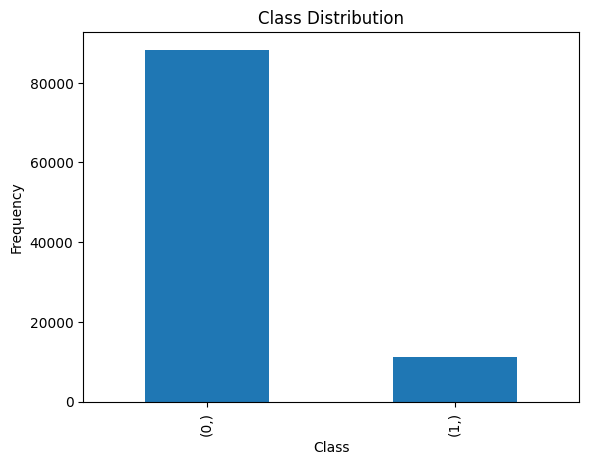

In [ ]:
#@title Plotting the distribution of y
class_counts = y.value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(X_data.shape)
print(y.shape)

(99492, 46)
(99492, 1)


# Normalize Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
training_proportion = 0.70
validation_proportion = 0.10
test_proportion = 0.20


X_train_val, X_test, y_train_val, y_test = train_test_split(X_data, y, test_size=test_proportion, random_state=42)
X_train,X_val, y_train,y_val = train_test_split(
    X_train_val, y_train_val, test_size=validation_proportion / (training_proportion + validation_proportion), random_state=42)


scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(69643, 46)
(19899, 46)
(69643, 1)
(19899, 1)


# Naive Bayes

Accuracy of using Naive Bayes: 0.8876325443489622
Accuracy of using Naive Bayes on training data: 0.887497666671453


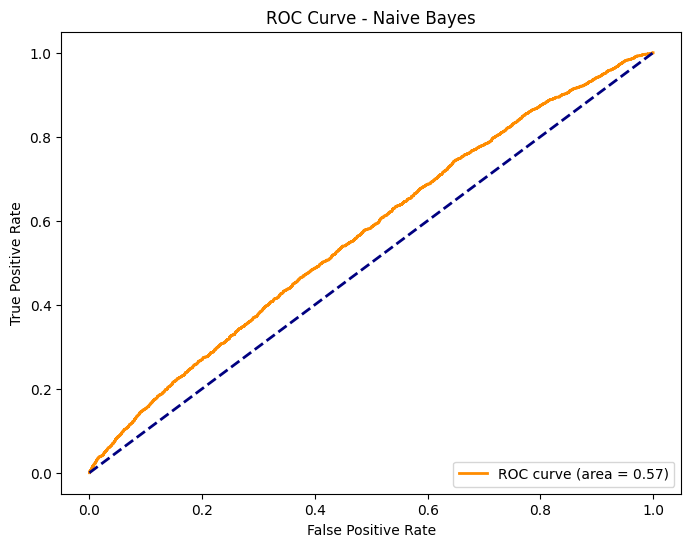

ROC-AUC Score for Naive Bayes: 0.5675926056277045


In [ ]:
y_train_column = y_train['readmitted']
y_train_array = y_train_column.values.ravel()
y_test_column = y_test['readmitted']
y_test_array = y_test_column.values.ravel()
classifier = MultinomialNB()
classifier.fit(X_train, y_train_array)
nb_predictions = classifier.predict(X_test)
nb_predictions_train = classifier.predict(X_train)
nb_accuracy = accuracy_score(y_test_array, nb_predictions)
nb_accuracy_train = accuracy_score(y_train_array, nb_predictions_train)
print("Accuracy of using Naive Bayes:", nb_accuracy)
print("Accuracy of using Naive Bayes on training data:", nb_accuracy_train)

# ROC-AUC
y_prob_nb = classifier.predict_proba(X_test)[:, 1]
nb_rocauc = roc_auc_score(y_test, y_prob_nb)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_nb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend(loc='lower right')
plt.show()

print('ROC-AUC Score for Naive Bayes:', nb_rocauc)

# SVM (Support Vector Machine)

Accuracy of using SVM: 0.8876325443489622
Accuracy of using SVM on training data: 0.887497666671453


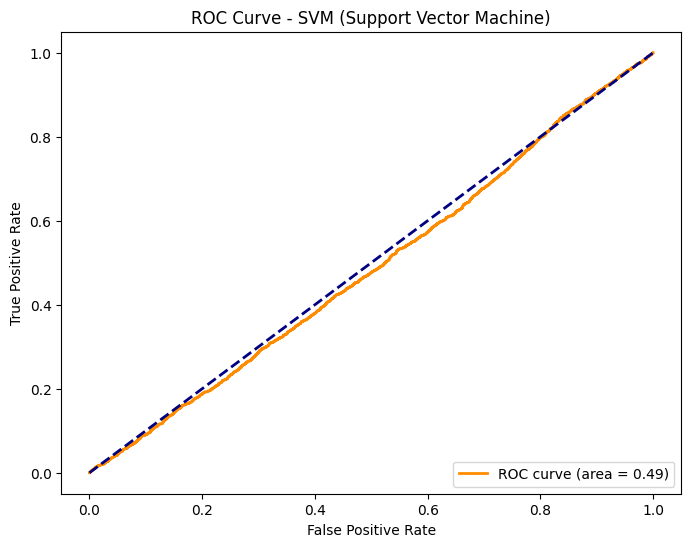

ROC-AUC Score for SVM (Support Vector Machine): 0.487313311828887


In [ ]:
# Standardized data
svm_classifier = SVC(kernel="linear", C=1.0, probability=True, random_state=42)
svm_classifier.fit(X_train, y_train_array)
svm_predictions = svm_classifier.predict(X_test)
svm_predictions_train = svm_classifier.predict(X_train)
svm_accuracy = accuracy_score(y_test_array, svm_predictions)
svm_accuracy_train = accuracy_score(y_train_array, svm_predictions_train)
print("Accuracy of using SVM:", svm_accuracy)
print("Accuracy of using SVM on training data:", svm_accuracy_train)

# ROC-AUC
y_prob_svm = svm_classifier.predict_proba(X_test)[:, 1]
svm_rocauc = roc_auc_score(y_test, y_prob_svm)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_svm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM (Support Vector Machine)')
plt.legend(loc='lower right')
plt.show()

print('ROC-AUC Score for SVM (Support Vector Machine):', svm_rocauc)

# Neural Networks

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_title('Binary crossentropy Loss Over Epochs')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.grid(True)
  ax1.legend()

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_title('Accuracy Over Epochs')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)
  ax2.legend()

  plt.show()

In [ ]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  # Step 1: Model Selection
  model = Sequential()
  model.add(Dense(num_nodes, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dropout(dropout_prob)) # randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  model.add(Dense(num_nodes, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
  model.add(Dropout(dropout_prob))
  model.add(Dense(1, activation='sigmoid'))

  # Step 2: Model Compilation
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Step 3: Model Training
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

  return model, history

16 nodes, dropout 0, lr 0.01, batch size 128


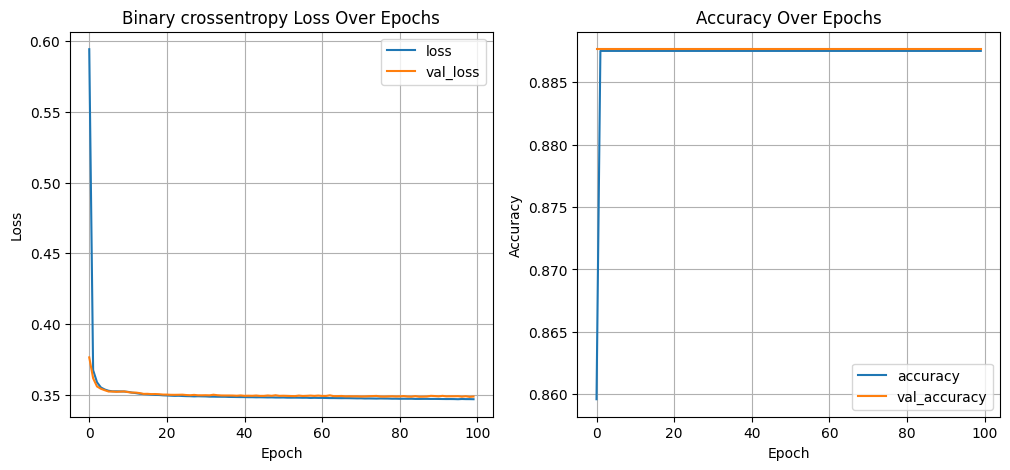

622/622 [==============================] - 2s 3ms/step - loss: 0.3486 - accuracy: 0.8876
Test Loss: 34.86%, Test Accuracy: 88.76%
16 nodes, dropout 0, lr 0.01, batch size 256


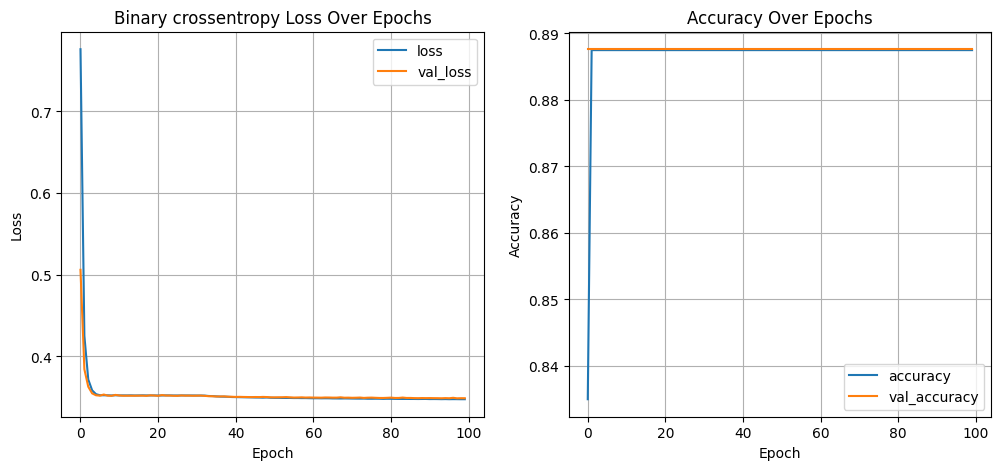

622/622 [==============================] - 2s 3ms/step - loss: 0.3489 - accuracy: 0.8876
Test Loss: 34.89%, Test Accuracy: 88.76%
16 nodes, dropout 0, lr 0.001, batch size 128


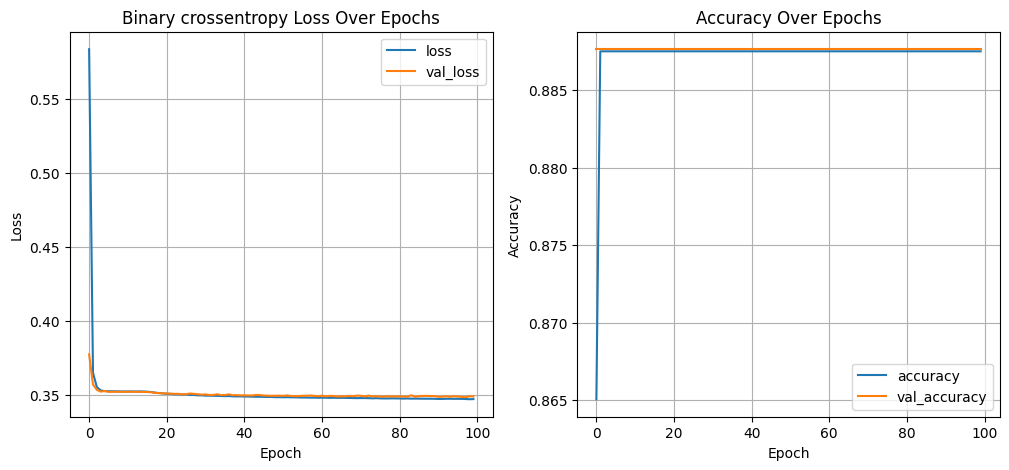

622/622 [==============================] - 1s 2ms/step - loss: 0.3489 - accuracy: 0.8876
Test Loss: 34.89%, Test Accuracy: 88.76%
16 nodes, dropout 0, lr 0.001, batch size 256


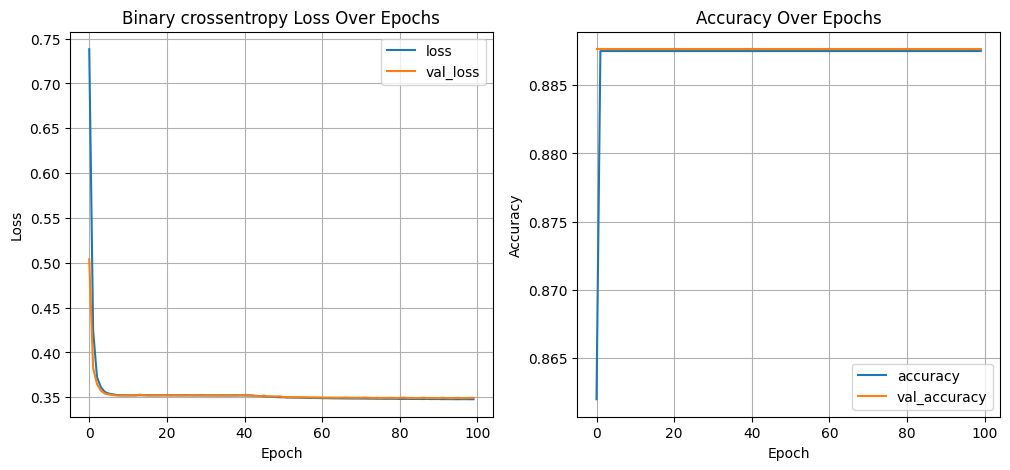

622/622 [==============================] - 1s 2ms/step - loss: 0.3493 - accuracy: 0.8876
Test Loss: 34.93%, Test Accuracy: 88.76%
16 nodes, dropout 0.2, lr 0.01, batch size 128


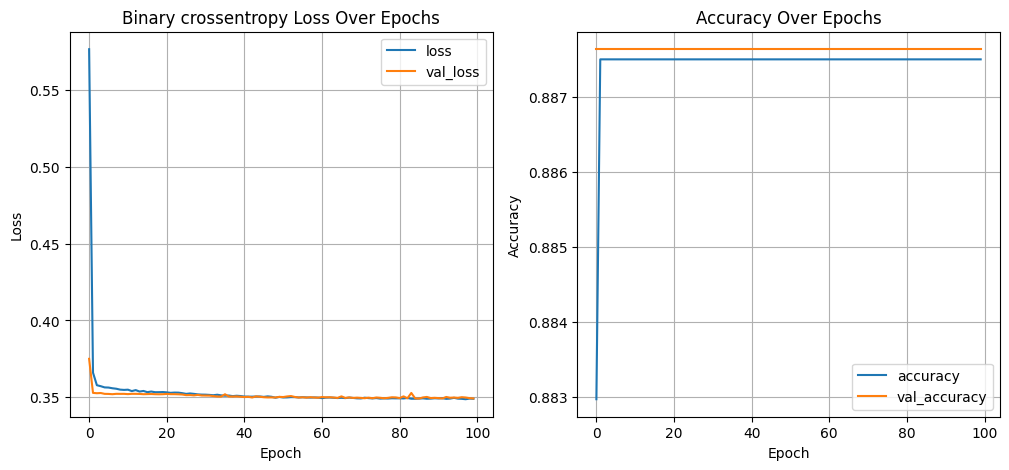

622/622 [==============================] - 2s 3ms/step - loss: 0.3491 - accuracy: 0.8876
Test Loss: 34.91%, Test Accuracy: 88.76%
16 nodes, dropout 0.2, lr 0.01, batch size 256


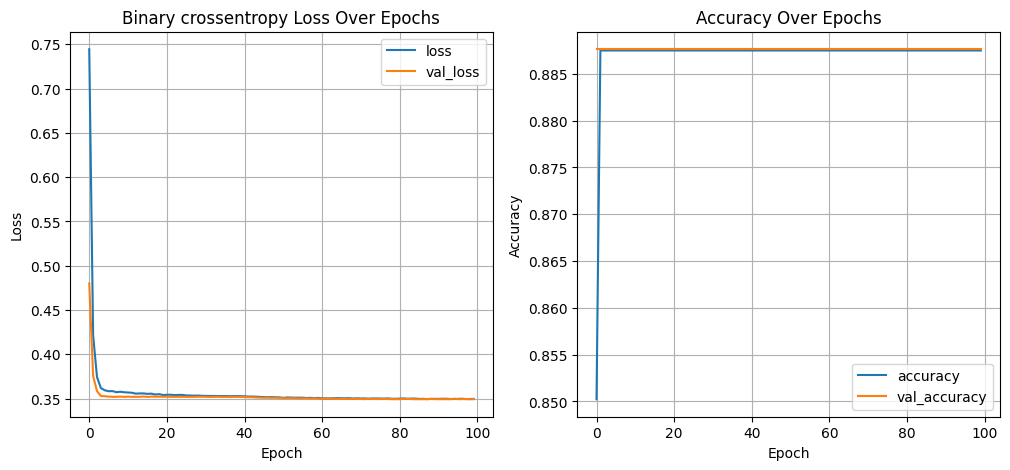

622/622 [==============================] - 2s 3ms/step - loss: 0.3493 - accuracy: 0.8876
Test Loss: 34.93%, Test Accuracy: 88.76%
16 nodes, dropout 0.2, lr 0.001, batch size 128


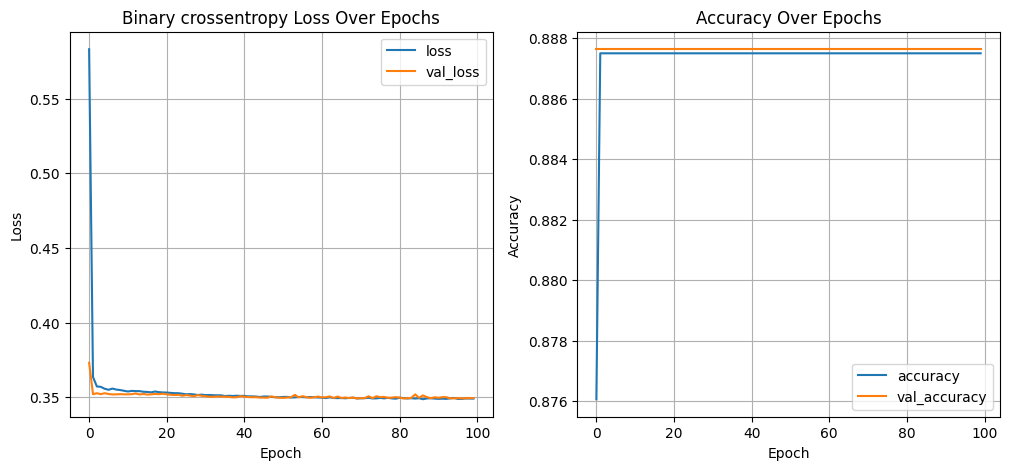

622/622 [==============================] - 1s 2ms/step - loss: 0.3496 - accuracy: 0.8876
Test Loss: 34.96%, Test Accuracy: 88.76%
16 nodes, dropout 0.2, lr 0.001, batch size 256


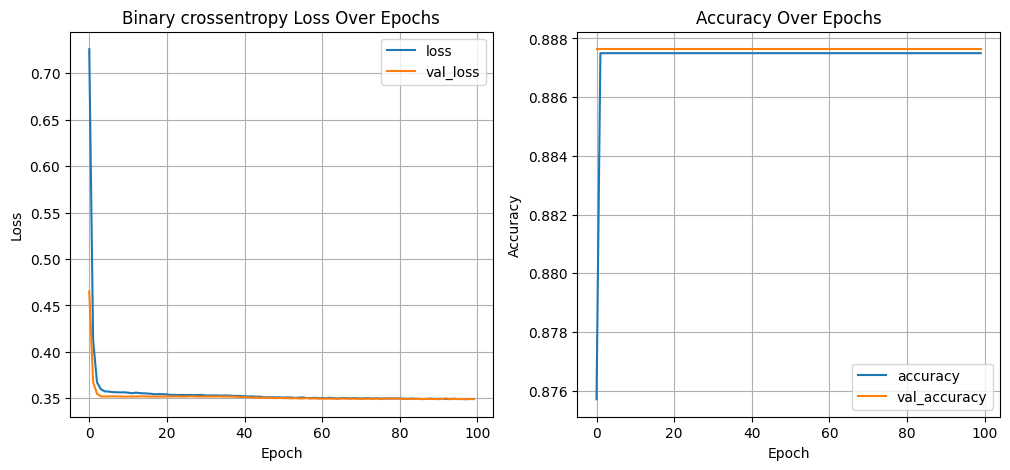

622/622 [==============================] - 1s 2ms/step - loss: 0.3493 - accuracy: 0.8876
Test Loss: 34.93%, Test Accuracy: 88.76%
32 nodes, dropout 0, lr 0.01, batch size 128


KeyboardInterrupt: ignored

In [ ]:
least_val_loss = float('inf')
least_loss_model = None
epochs = 100
best_hyperparameters = {}

for num_nodes in [16, 32]:
  for dropout_prob in [0, 0.2]:
    for lr in [0.01, 0.001]:
      for batch_size in [128, 256]:
        print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
        model, history = train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
        plot_history(history)
        eval_results = model.evaluate(X_test, y_test)
        print(f"Test Loss: {eval_results[0]:.2%}, Test Accuracy: {eval_results[1]:.2%}")
        if eval_results[0] < least_val_loss:
          least_val_loss = eval_results[0]
          least_loss_accuracy = eval_results[1]
          least_loss_model = model
          best_hyperparameters = {
              'num_nodes': num_nodes,
              'dropout_prob': dropout_prob,
              'lr': lr,
              'batch_size': batch_size,
              'epochs': epochs
          }

print("Best Hyperparameters:")
print(best_hyperparameters)
print(f"Test Loss: {least_val_loss:.2%}, Test Accuracy: {least_loss_accuracy:.2%}")
plot_history(history)

In [ ]:
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)
print(classification_report(y_test, y_pred))

622/622 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17663
           1       0.00      0.00      0.00      2236

    accuracy                           0.89     19899
   macro avg       0.44      0.50      0.47     19899
weighted avg       0.79      0.89      0.83     19899



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


622/622 [==============================] - 1s 2ms/step


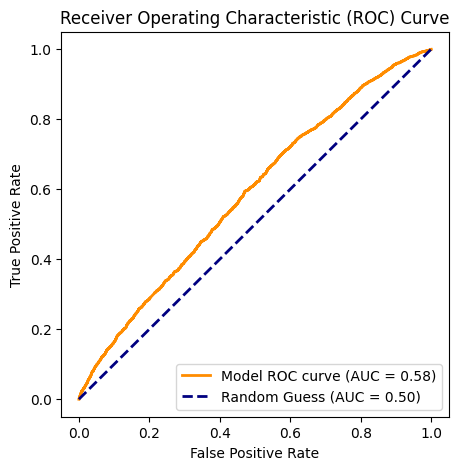

In [ ]:
# Interpretation and Insights
from sklearn.metrics import roc_curve, auc
y_pred_prob = least_loss_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Model ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(fpr,tpr)

[0.         0.         0.         ... 0.99977354 0.99977354 1.        ] [0.00000000e+00 4.47227191e-04 8.94454383e-04 ... 9.99552773e-01
 1.00000000e+00 1.00000000e+00]


In [ ]:
#@title Using SMOTE and Stratified K-fold cross validation on NN
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
import numpy as np

def train_model_with_cv(X, y, num_folds=5):
    #stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    smote = SMOTE(random_state=42)   # Initialize SMOTE

    histories = []
    auc_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, y)):
        # Create data for this fold
        X_train_fold, X_val_fold = X_data.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        X_train_fold_smote, y_train_fold_smote = smote.fit_resample(X_train_fold, y_train_fold)
        # using the least loss model
        history = train_model(X_train_fold_smote, y_train_fold_smote, 16, 0, 0.001, 128, 100)

        # Store the history
        histories.append(history)

        # Predict the probabilities on the validation set
        y_val_pred_probs = model.predict(X_val_fold)

        # Calculate ROC-AUC and store the score
        auc_score = roc_auc_score(y_val_fold, y_val_pred_probs)
        auc_scores.append(auc_score)

        print(f"Fold {fold+1}/{num_folds} | ROC-AUC: {auc_score}")

    return histories, auc_scores


histories, auc_scores = train_model_with_cv(X_data, y, num_folds=5) #call the function with your data

# Calculate average and standard deviation of the AUC scores across folds
mean_auc_score = np.mean(auc_scores)
std_auc_score = np.std(auc_scores)
print(f"Mean ROC-AUC: {mean_auc_score:.3f}")
print(f"Standard Deviation ROC-AUC: {std_auc_score:.3f}")


622/622 [==============================] - 1s 2ms/step
Fold 1/5 | ROC-AUC: 0.5546540471082093


KeyboardInterrupt: ignored

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
def train_logistic_regression(X_train, y_train, X_test, y_test):
    # Model Selection
    model = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', max_iter=1000)

    # Model Training
    model.fit(X_train, y_train)

    #  Model Evaluation
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Print accuracy
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)

    print(f"Training Accuracy with threshold of 0.5: {train_accuracy:.2%}")
    print(f"Test Accuracy with threshold of 0.5: {test_accuracy:.2%}")

    return model, train_preds, test_preds

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy with threshold of 0.5: 88.75%
Test Accuracy with threshold of 0.5: 88.76%


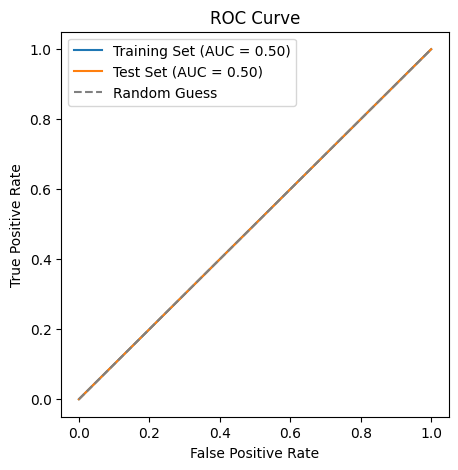

Training Set ROC AUC: 50.00%
Test Set ROC AUC: 50.00%


In [ ]:
logistic_model, train_preds, test_preds = train_logistic_regression(X_train, y_train, X_test, y_test)

# Calculate ROC curve and AUC for training set
fpr_train, tpr_train, _ = roc_curve(y_train, train_preds)
roc_auc_train = roc_auc_score(y_train, train_preds)

# Calculate ROC curve and AUC for test set
fpr_test, tpr_test, _ = roc_curve(y_test, test_preds)
roc_auc_test = roc_auc_score(y_test, test_preds)

# Plot ROC curves
plt.figure(figsize=(5, 5))
plt.plot(fpr_train, tpr_train, label=f'Training Set (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test Set (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f"Training Set ROC AUC: {roc_auc_train:.2%}")
print(f"Test Set ROC AUC: {roc_auc_test:.2%}")

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def gradsigmoid(x):
  return sigmoid * (1 - sigmoid(x))

In [ ]:
def logreg(W, x, b):
  return sigmoid( (W @ x.T).T + b)

In [ ]:
def costfxn(y, W, x, b):
  '''
  Calculate the overall binary cross-entropy cost function

  Args:
    * y: N x m matrix
    * W: m x d matrix
    * x: N x d matrix of data
    * b: m offsite vector

  Returns:
    * A scalar cost value (summed over all data in the batch)
  '''
  yhat = logreg(W, x, b)
  return -np.sum( y * np.log(yhat) + ( 1 - y ) * np.log(1 - yhat) )


def gradW(y, W, x, b):
  '''
  Calculate the gradient w/r/t W

  Args:
    * y: N x m matrix
    * W: m x d matrix
    * x: N x d matrix of data
    * b: m offsite vector

  Returns:
    * gradient of size m x d
  '''
  yhat = logreg(W, x, b)
  return (np.expand_dims(yhat - y, 2) * np.expand_dims(x, 1)).sum(axis=0)

def gradb(y, W, x, b):
  '''
  Calculate the gradient w/r/t b

  Args:
    * y: N x m matrix
    * W: m x d matrix
    * x: N x d matrix of data
    * b: m offset vector

  Returns:
    * gradient of size N x m
  '''
  yhat = logreg(W, x, b)
  return (yhat - y).sum(axis=0)

Training Accuracy: 88.51%, Final Loss: 5.7e+01


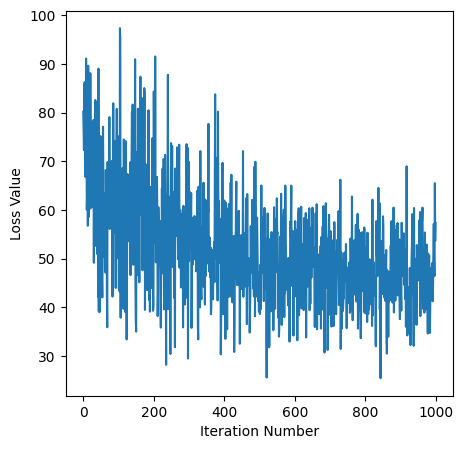

Training Set AUC: 52.52%
Testing Set AUC: 52.43%


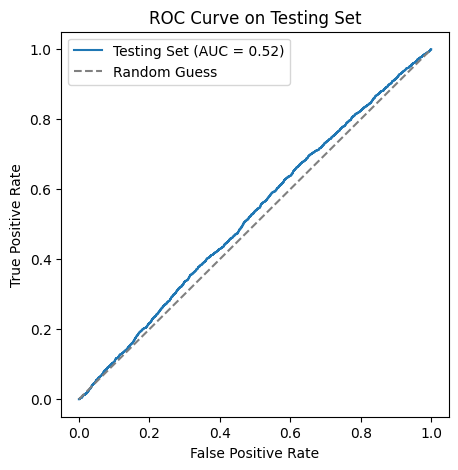

In [ ]:
# Parameters
num_iters = 1000
batch_size = 128
learn_rate = 0.001
reg_strength = 0.01

random_range = np.random.default_rng(len(X_train))

# Randomly initialize weights and bias
num_features = X_train.shape[1]
num_labels = 1

W = np.random.randn(num_labels, num_features)
b = np.random.randn(num_labels)

# Iterate through num_iters
L = []
for i in range(num_iters):
    # Take a random training sample
    rand_sample = random_range.integers(low=0, high=len(X_train), size=batch_size)

    # Features
    xtrain_batch = X_train[rand_sample]
    ytrain_batch = y_train.iloc[rand_sample].values.reshape(-1, 1)

    # Calculate cost function and the gradient with regularization
    gradient_W = gradW(ytrain_batch, W, xtrain_batch, b) + reg_strength * W
    gradient_b = gradb(ytrain_batch, W, xtrain_batch, b)

    # Update weights and bias
    W -= learn_rate * gradient_W
    b -= learn_rate * gradient_b

    # Calculate the cost function with regularization
    cost = costfxn(ytrain_batch, W, xtrain_batch, b) + 0.5 * reg_strength * np.sum(W**2)
    L.append(cost)

yhat = logreg(W, X_train, b)
train_accuracy = accuracy_score(y_train, (yhat >= 0.5).astype(int))
print(f"Training Accuracy: {train_accuracy:.2%}, Final Loss: {L[-1]:.2}")
# Plot the loss curve
plt.figure(figsize=(5, 5))
plt.plot(L)
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')
plt.show()

fpr, tpr, _ = roc_curve(y_train, yhat)
roc_auc = roc_auc_score(y_train, yhat)

yhat_test_probs = logreg(W, X_test, b)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, yhat_test_probs)
roc_auc_test = roc_auc_score(y_test, yhat_test_probs)

# Print AUC
print(f"Training Set AUC: {roc_auc:.2%}")
print(f"Testing Set AUC: {roc_auc_test:.2%}")

# Plot ROC curve on the testing set
plt.figure(figsize=(5, 5))
plt.plot(fpr_test, tpr_test, label=f'Testing Set (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Testing Set')
plt.legend()
plt.show()


In [ ]:
#@title Random Forest Classifier Baseline Model using K-fold Cross-Validation
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

X_data_normalized = scaler.fit_transform(X_data)
y_data = y.values.ravel()
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42) #initialize random forest classifier

# use k-fold cross-validation with 5 folds
k_fold = KFold(n_splits=5, random_state=42, shuffle=True)

scoring_metrics = {
    'roc_auc': 'roc_auc',
    'f1_score': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score)
}

y_data = y.values.ravel()

cv_results = cross_validate(rf_classifier, X_data_normalized , y_data, cv=k_fold, scoring=scoring_metrics)

for metric_name, scores in cv_results.items():
    if metric_name.startswith('test_'):
        metric_name_clean = metric_name[5:]
        print(f"{metric_name_clean.capitalize()} CV scores: {scores}")
        print(f"Mean {metric_name_clean.capitalize()}: {scores.mean():.4f}")
        print(f"Standard Deviation {metric_name_clean.capitalize()}: {scores.std():.4f}\n")


Roc_auc CV scores: [0.58828482 0.59739795 0.59380115 0.59651614 0.59598266]
Mean Roc_auc: 0.5944
Standard Deviation Roc_auc: 0.0033

F1_score CV scores: [0.0053286  0.00910747 0.00172936 0.00360848 0.00352734]
Mean F1_score: 0.0047
Standard Deviation F1_score: 0.0025

Precision CV scores: [0.375      0.43478261 0.18181818 0.23529412 0.4       ]
Mean Precision: 0.3254
Standard Deviation Precision: 0.0987

Recall CV scores: [0.00268336 0.00460193 0.00086881 0.00181818 0.00177148]
Mean Recall: 0.0023
Standard Deviation Recall: 0.0013

Accuracy CV scores: [0.88743153 0.89064777 0.88395819 0.88898382 0.88642075]
Mean Accuracy: 0.8875
Standard Deviation Accuracy: 0.0023



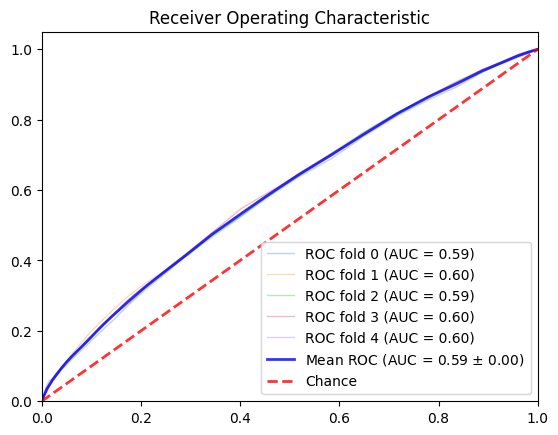

In [ ]:
#@title Plotting ROC AUC for Balanced Random Forest Classifier
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train_index, test_index) in enumerate(kf.split(X_data_normalized, y_data)):
    X_train, X_test = X_data_normalized[train_index], X_data_normalized[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()


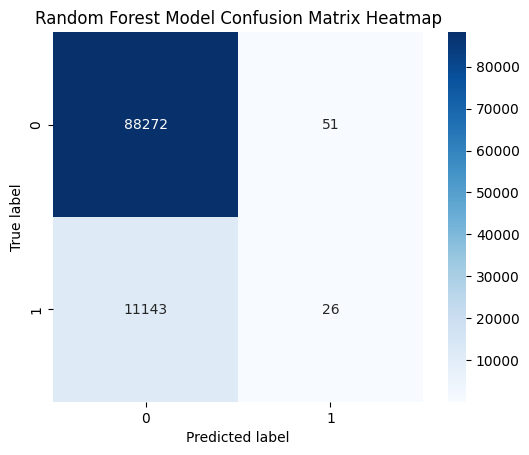

In [ ]:
#@title Data Visualization: Confusion Matrix Heat Map for Random Forest Classifier
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from imblearn.pipeline import Pipeline

y_pred = cross_val_predict(rf_classifier,X_data_normalized, y_data, cv=k_fold)

conf_mat = confusion_matrix(y_data, y_pred)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest Model Confusion Matrix Heatmap')
plt.show()

In [ ]:
#@title Adjust class weights for Random Forest Classifier Model using K-fold Cross-Validation

y_data = y.values.ravel()
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight='balanced',random_state=42) #initialize random forest classifier

# use k-fold cross-validation with 5 folds
k_fold = KFold(n_splits=5, random_state=42, shuffle=True)

cv_results = cross_validate(rf_classifier, X_data_normalized , y_data, cv=k_fold, scoring=scoring_metrics)

for metric_name, scores in cv_results.items():
    if metric_name.startswith('test_'):
        metric_name_clean = metric_name[5:]
        print(f"{metric_name_clean.capitalize()} CV scores: {scores}")
        print(f"Mean {metric_name_clean.capitalize()}: {scores.mean():.4f}")
        print(f"Standard Deviation {metric_name_clean.capitalize()}: {scores.std():.4f}\n")


Roc_auc CV scores: [0.58792659 0.60597557 0.59801593 0.59932524 0.60552499]
Mean Roc_auc: 0.5994
Standard Deviation Roc_auc: 0.0065

F1_score CV scores: [0.00355398 0.00547695 0.00259291 0.00270758 0.00527241]
Mean F1_score: 0.0039
Standard Deviation F1_score: 0.0012

Precision CV scores: [0.26666667 0.33333333 0.25       0.1875     0.33333333]
Mean Precision: 0.2742
Standard Deviation Precision: 0.0551

Recall CV scores: [0.00178891 0.00276116 0.00130321 0.00136364 0.00265722]
Mean Recall: 0.0020
Standard Deviation Recall: 0.0006

Accuracy CV scores: [0.88728077 0.89049701 0.88400844 0.88893356 0.88621972]
Mean Accuracy: 0.8874
Standard Deviation Accuracy: 0.0022



In [ ]:
#@title Random Forest Classifier with SMOTE and Stratified K-fold validation
from sklearn.model_selection import cross_validate, StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


stratified_k_fold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#apply SMOTE and fit RandomForestClassifier
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

scoring_metrics = {
    'roc_auc': 'roc_auc',
    'f1_score': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score)
}

y_data = y.values.ravel()
# Perform cross-validation and collect metrics
cv_results = cross_validate(pipeline, X_data_normalized , y_data, cv=stratified_k_fold, scoring=scoring_metrics)

for metric_name, scores in cv_results.items():
    if metric_name.startswith('test_'):
        metric_name_clean = metric_name[5:]
        print(f"{metric_name_clean.capitalize()} CV scores: {scores}")
        print(f"Mean {metric_name_clean.capitalize()}: {scores.mean():.4f}")
        print(f"Standard Deviation {metric_name_clean.capitalize()}: {scores.std():.4f}\n")


Roc_auc CV scores: [0.59401854 0.59117189 0.58378174 0.59430858 0.58912177]
Mean Roc_auc: 0.5905
Standard Deviation Roc_auc: 0.0039

F1_score CV scores: [0.03739094 0.04213135 0.04128819 0.0307309  0.04      ]
Mean F1_score: 0.0383
Standard Deviation F1_score: 0.0041

Precision CV scores: [0.26011561 0.27272727 0.26455026 0.21264368 0.28915663]
Mean Precision: 0.2598
Standard Deviation Precision: 0.0256

Recall CV scores: [0.02014324 0.02282901 0.0223914  0.01656222 0.02148612]
Mean Recall: 0.0207
Standard Deviation Recall: 0.0023

Accuracy CV scores: [0.88356199 0.88346148 0.88330485 0.88270178 0.88420947]
Mean Accuracy: 0.8834
Standard Deviation Accuracy: 0.0005



In [ ]:
#@title Data Visualization: Confusion Matrix Heat Map for Random Forest Classifier

y_pred = cross_val_predict(pipeline, X_data, y_data, cv=stratified_k_fold)

conf_mat = confusion_matrix(y_data, y_pred)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest Model Confusion Matrix Heatmap')
plt.show()


In [ ]:
#@title Balanced Random Forest Classifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

#BalancedRandomForestClassifier
brfc = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

#using random forest classifier as base estimator
bbc = BalancedBaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=10, random_state=42),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=42)
#pipeline with SMOTE and RandomForestClassifier with balanced class weights
pipeline_rfc = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', rf_classifier)
])

cv_results_brfc = cross_validate(brfc, X_data, y_data, cv=stratified_k_fold, scoring=scoring_metrics)

print("\nBalancedRandomForestClassifier:")
for metric_name, scores in cv_results_brfc.items():
    if metric_name.startswith('test_'):
        print(f"{metric_name}: Mean: {scores.mean():.3f}, Std: {scores.std():.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para


BalancedRandomForestClassifier:
test_roc_auc: Mean: 0.615, Std: 0.007
test_f1_score: Mean: 0.238, Std: 0.005
test_precision: Mean: 0.150, Std: 0.003
test_recall: Mean: 0.582, Std: 0.008
test_accuracy: Mean: 0.582, Std: 0.005


In [ ]:
pip install xgboost

In [ ]:
#@title XGBoost Model

import xgboost as xgb
from sklearn.metrics import accuracy_score

# Convert the dataset into an optimized data structure called Dmatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc'
}

# Specify validations set to watch performance
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Train the model
bst = xgb.train(params, dtrain, num_boost_round=100, evals=watchlist, early_stopping_rounds=10)

# Predict the probabilities instead of classes
y_test_pred_probs = bst.predict(dtest)

# Convert probabilities to 0-1 binary classification
y_test_pred = [1 if prob > 0.5 else 0 for prob in y_test_pred_probs]
print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")



[0]	train-auc:0.62392	eval-auc:0.60684
[1]	train-auc:0.63699	eval-auc:0.61210
[2]	train-auc:0.64360	eval-auc:0.61599
[3]	train-auc:0.64770	eval-auc:0.61742
[4]	train-auc:0.65310	eval-auc:0.61924
[5]	train-auc:0.66010	eval-auc:0.62034
[6]	train-auc:0.66541	eval-auc:0.62026
[7]	train-auc:0.66978	eval-auc:0.62056
[8]	train-auc:0.67376	eval-auc:0.62160
[9]	train-auc:0.67829	eval-auc:0.62208
[10]	train-auc:0.68323	eval-auc:0.62312
[11]	train-auc:0.68649	eval-auc:0.62412
[12]	train-auc:0.68766	eval-auc:0.62419
[13]	train-auc:0.69126	eval-auc:0.62409
[14]	train-auc:0.69315	eval-auc:0.62335
[15]	train-auc:0.69555	eval-auc:0.62391
[16]	train-auc:0.69583	eval-auc:0.62496
[17]	train-auc:0.69844	eval-auc:0.62499
[18]	train-auc:0.70018	eval-auc:0.62483
[19]	train-auc:0.70101	eval-auc:0.62516
[20]	train-auc:0.70284	eval-auc:0.62497
[21]	train-auc:0.70597	eval-auc:0.62413
[22]	train-auc:0.70699	eval-auc:0.62477
[23]	train-auc:0.70939	eval-auc:0.62431
[24]	train-auc:0.71144	eval-auc:0.62412
[25]	train

In [ ]:
#@title Using Stratified K-fold cross validation for XGBoost Classifier

from sklearn.model_selection import StratifiedKFold

X_data_normalized = scaler.fit_transform(X_data)
dtrain = xgb.DMatrix(X_data_normalized, label=y_data)

# Define the parameters for the XGBoost model
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',  # Evaluation metric for cross-validation
    # Define more parameters here
}

# Perform cross-validation
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # Number of boosting rounds
    nfold=5,  # Number of folds for CV
    stratified=True,  # Whether to perform stratified sampling
    early_stopping_rounds=10,  # Stops CV if performance doesn't improve for n rounds
    seed=42
)

# cv_results contains train and test metrics for each boosting round
# Extract and print the final boosting round's results
print(f"Train AUC: {cv_results['train-auc-mean'].iloc[-1]}, Test AUC: {cv_results['test-auc-mean'].iloc[-1]}")


Train AUC: 0.714944403417906, Test AUC: 0.6299978434346469


In [ ]:
#@title Finding best parameters for XGB Classifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_model = XGBClassifier(use_label_encoder=False)
y_train = y_train.values.ravel()
param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'scale_pos_weight': [1, (len(y_train) - sum(y_train)) / sum(y_train)]  # for imbalanced data
}

grid_search = GridSearchCV(xgb_model, param_grid, scoring='roc_auc', n_jobs=-1, cv=3)
grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")


In [ ]:
#@title Using best parameters to tune XGB Classifier

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

dtrain = xgb.DMatrix(X_data_normalized, label=y_data)

# update XGBoost parameters with the best parameters found from GridSearchCV
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,  # Updated from GridSearchCV results
    'min_child_weight': 1,  # Updated from GridSearchCV results
    'eta': 0.01,  # learning rate, Updated from GridSearchCV results
    'subsample': 0.7,  # Updated from GridSearchCV results
    'colsample_bytree': 0.5,  # Updated from GridSearchCV results
    'scale_pos_weight': 1,  # Updated from GridSearchCV results if it's for imbalanced data
    'n_estimators': 200
}

# Perform cross-validation
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=params['n_estimators'],
    nfold=5,
    stratified=True,
    early_stopping_rounds=10,  #Stops CV if performance doesn't improve for n rounds
    seed=42
)

# Extract and print the final boosting round's results
print(f"Train AUC: {cv_results['train-auc-mean'].iloc[-1]}")
print(f"Test AUC: {cv_results['test-auc-mean'].iloc[-1]}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:55:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:55:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Train AUC: 0.6530791406762873
Test AUC: 0.6292214554755686


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:56:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:56:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:56:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:56:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:56:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.



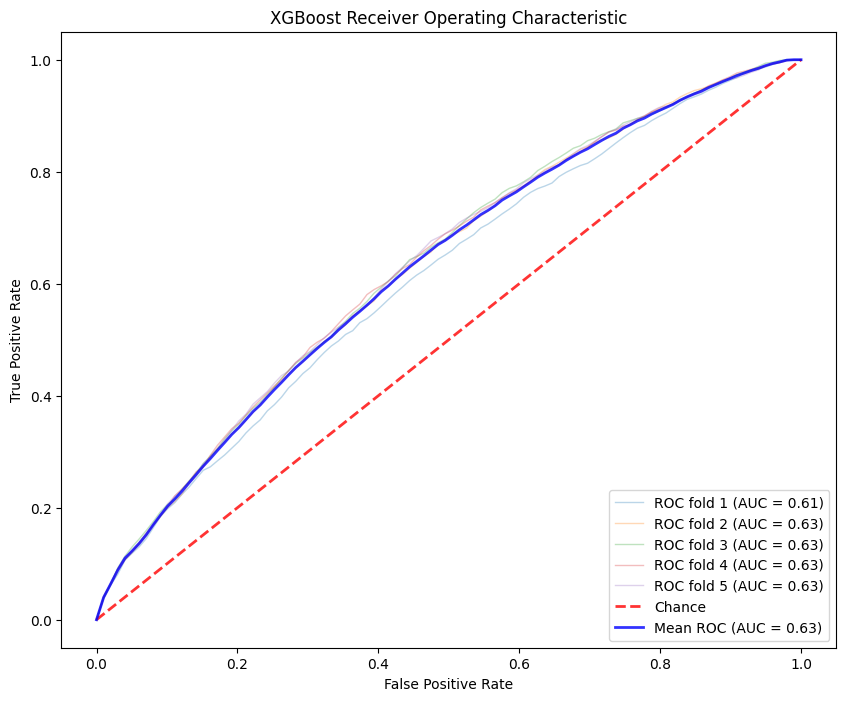

In [ ]:
#@title Data Visualizaiton for XGBoost Model Results

tprs = []  # True positive rates
aucs = []  # Area under curve values
mean_fpr_xg = np.linspace(0, 1, 100)  # Mean false positive rates
conf_matrix_list_of_arrays = []  # List to hold confusion matrices from each fold

# Initialize cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
for train_index, test_index in kf.split(X_data_normalized, y_data):
    X_train, X_test = X_data_normalized[train_index], X_data_normalized[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    bst = xgb.train(params, dtrain, num_boost_round=params['n_estimators'])

    # Predict on the test set
    y_test_pred_probs = bst.predict(dtest)
    y_test_pred = (y_test_pred_probs > 0.5).astype(int)

    # Compute ROC curve for this fold
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_probs)
    tprs.append(np.interp(mean_fpr_xg, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

# Plot ROC-AUC graph
plt.figure(figsize=(10, 8))
for i in range(len(tprs)):
    plt.plot(mean_fpr_xg, tprs[i], lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {aucs[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
mean_tpr_xg = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr_xg, mean_tpr_xg)
plt.plot(mean_fpr_xg, mean_tpr_xg, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2, alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Aggregated ROC-AUC

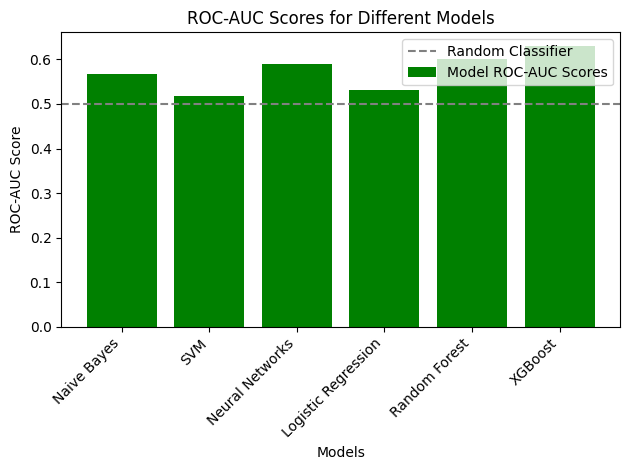

In [ ]:
model_names = ['Naive Bayes', 'SVM', 'Neural Networks', 'Logistic Regression', 'Random Forest', 'XGBoost']
roc_auc_scores = [0.5675, 0.5187, 0.59, 0.5322, 0.6, 0.6293]  # Replace with your actual scores

fig, ax = plt.subplots()
ax.bar(np.arange(len(model_names)), roc_auc_scores, color='green', label='Model ROC-AUC Scores')
ax.set_xticks(np.arange(len(model_names)))
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.axhline(y=0.5, color='gray', linestyle='--', label='Random Classifier')
ax.set_xlabel('Models')
ax.set_ylabel('ROC-AUC Score')
ax.set_title('ROC-AUC Scores for Different Models')
ax.legend()
plt.tight_layout()
plt.show()

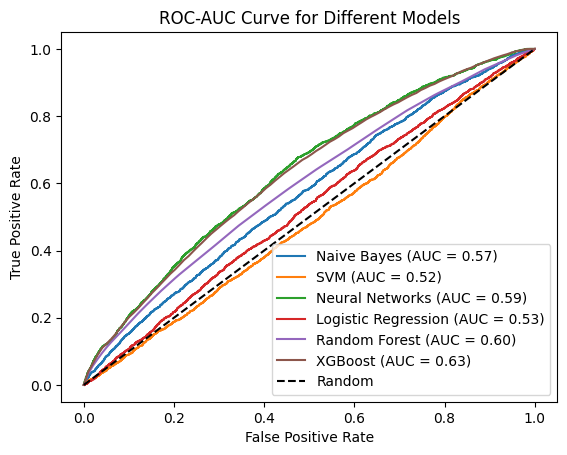

In [ ]:
model_names = ['Naive Bayes', 'SVM', 'Neural Networks', 'Logistic Regression', 'Random Forest', 'XGBoost']
roc = [(fpr_nb, tpr_nb), (fpr_svm, tpr_svm), (fpr, tpr), (fpr_test, tpr_test), (mean_fpr, mean_tpr), (mean_fpr_xg, mean_tpr_xg)]  # Replace with your actual scores

# Create a figure and axis
fig, ax = plt.subplots()

# Plot ROC-AUC curve for each model
for i in range(len(model_names)):
    fpr_temp, tpr_temp = roc[i]
    plt.plot(fpr_temp, tpr_temp, label=f'{model_names[i]} (AUC = {roc_auc_scores[i]:.2f})')

# Plot ROC curve for a random classifier (dashed line)
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Different Models')
plt.legend(loc='lower right')

# Show the plot
plt.show()